# Parte opcional extra sobre "Detección de bordes"

Una vez hemos llevado a cabo las partes obligatorias de la práctica sobre esta parte del temario de la asignatura, he decidido tratar de implementar algunas funcionalidades más que sirvan como "aplicación" de todo lo aprendido a lo largo de las secciones anteriores. Concretamente voy a tratar de llevar a cabo una serie de funciones que me permitan elegir cuál es el objeto mas grande de una determinada imagen. Para ello, haré uso de algunos métodos que se han realizado en la parte obligatoria de la practica. La idea general, es parecida a una aplicacion muy comun en el campo de la "Vision por Computador" como es el encontrar regiones grandes o caracteristicas por su tamaño en determinadas imagenes:

<center><img src="./images/60118object counting.jpg" width="600"></center>

<center><img src="./images/region_proposal_object_detection_output_beagle_before.png" width="600"></center>

He decidido llevar esta aplicacion a objetos, ya que segun nuestros conocimientos creo que el hecho de tener una imagen con cosas separadas va a facilitarme bastante el trabajo, y esto presentará una mayor comodidad a las funciones a la hora de identificar contornos cerrados y diferentes. Como primer proposito podemos mostrar la primera imagen que vamos a analizar:

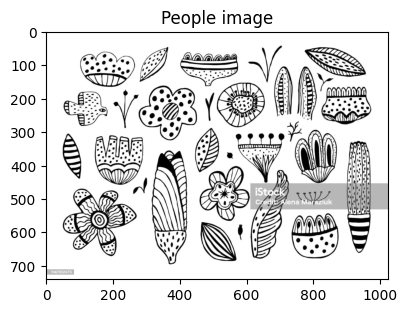

In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = './images/'

# Read the images
medical_1 = cv2.imread(images_path + "objeto2.jpg", 0)

# And show them
plt.subplot(131)
plt.imshow(medical_1, cmap = 'gray')
plt.title('People image')

plt.show()

Como vemos la imagen presenta a 12 personas en blanco y negro, separadas por una notable distancia. Una vez hemos mostrado por pantalla nuestro caso de uso que vamos a analizar, procedemos a desarrollar las funciones necesarias para la deteccion de bordes y el posterior conteo de objetos (personas en este caso).

In [2]:
def edge_detection_chart(image, kernel_h, kernel_v, threshold, verbose=False):
    """ Computed the gradient of the image, binarizes and display it.   
    
        Args:
            image: Input image
            kernel_h: kernel for horizontal derivative
            kernel_v: kernel for vertical derivative
            threshold: threshold value for binarization
            verbose: Only show images if this is True
            
        Returns:
            edges: edges binary image
    """
    # Write your code here!
    
    # Compute derivatives
    d_h = cv2.filter2D(image, cv2.CV_16S, kernel_h) # horizontal
    d_v = cv2.filter2D(image, cv2.CV_16S, kernel_v) # vertical
    
    # Compute gradient
    gradient_image = np.add(np.absolute(d_h),np.absolute(d_v)) # Hint: You have to sum both derivatives in absolute value!
    
    #Normalize gradient
    norm_gradient = np.copy(image)
    norm_gradient = cv2.normalize(gradient_image, None, 0, 255, cv2.NORM_MINMAX)
    
    # Threshold to get edges
    ret, edges = cv2.threshold(norm_gradient, threshold, 255,cv2.THRESH_BINARY) # el tercer argumento es el valor que se le dara a aquellos pixeles que superer el threshold
    # devuelve como primer parametro el umbral real que se utilizó. Esto puede ser útil si se utiliza un valor de umbral automático.
    
    if verbose:
        # Show the initial image
        plt.subplot(131)
        plt.imshow(image, cmap = 'gray')
        plt.title('Original image')

        # Show the gradient image
        plt.subplot(132)
        plt.imshow(gradient_image, cmap = 'gray')
        plt.title('Gradient image')

        # Show edges image
        plt.subplot(133)
        plt.imshow(edges, cmap = 'gray')
        plt.title('Edges detected')
    
    return edges

In [3]:
def biggestObject(image, kernel_h, kernel_v, threshold, verbose=False):
    # Aplicar detección de bordes
    edges = edge_detection_chart(image, kernel_h, kernel_v, threshold, verbose=False)

    edges = np.uint8(edges)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask
    mask = np.zeros_like(image)

    # Find the largest contour (contour with the maximum area)
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
      
    if verbose:
        # Mostrar la imagen original
        plt.subplot(131)
        plt.imshow(image, cmap='gray')
        plt.title('Imagen Original')

        # Mostrar la imagen de bordes
        plt.subplot(132)
        plt.imshow(edges, cmap='gray')
        plt.title('Gradient image')

        # Mostrar la imagen con contornos válidos
        plt.subplot(133)
        plt.imshow(mask,cmap = 'gray')
        plt.title("Largest Contour")
    
    return mask

La función principal en esta aplicacion es claramente "biggestObject", la cual se apoya en una funcion secundaria pero que tiene gran peso en la funcionalidad de esta herramienta, como explicaremos ahora más adelante. La funcion "biggestObject" recibe por parametro una imagen, 2 kernels (uno horizontal y otro vertical)y un threshold, parametros que principalmente se usaran para llamaran a la segunda funcion importante de la que hemos hablado.

Lo primero que hacemos es guardarnos en una variable "edges" la salida de la funcion secundaria que mencionabamos anteriormente, "edge_detection_chart", la cual recibe como parametros la imagen, los kernels y el threshold, y que calcula la imagen de gradiente de una entrada utilizando kernel_h y kernel_v (kernels para derivadas horizontales y verticales respectivamente) y binariza la imagen resultante (imagen de bordes final) utilizando "threshold".

Una vez tenemos la imagen gradiente que muestra los bordes de la que hemos pasado por parametro, usamos np.uint8() que realiza la conversión de una matriz de datos llamada "edges" a valores de tipo de datos "uint8" en NumPy. Las siguientes lineas de codigo son la magia de la funcion.

La primera de ellas, por un lado, es "findContours" que como su propio nombre indica se dedica a devolver los contornos de una imagen dada (en este caso la imagen gradiente). La segunda, mask = np.zeros_like(image) donde se crea una matriz de ceros (0) llamada mask que tiene las mismas dimensiones que la imagen original (image). Esta matriz se utilizará para dibujar el contorno más grande.

Una vez creada esta matriz, largest_contour = max(contours, key=cv2.contourArea) busca el contorno más grande en la lista de contornos (contours). La función max se utiliza junto con cv2.contourArea como la clave para encontrar el contorno con el área máxima. Por ultimo, cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED) linea donde el contorno más grande se dibuja en la máscara mask con un valor de píxel de (255, 255, 255), que representa blanco. La opción thickness=cv2.FILLED indica que se deben llenar todas las áreas dentro del contorno, para que de esta manera se note y vea mejor cual es el objeto mas grande de la imagen que estamos computando.

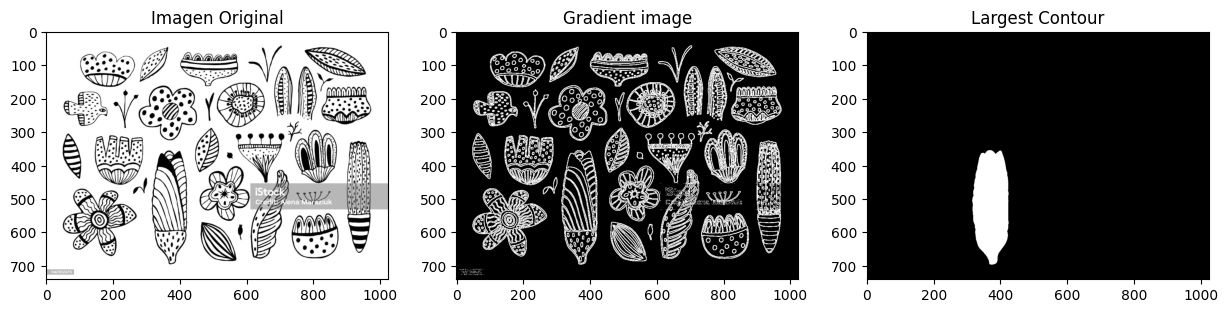

In [4]:
#medical_1
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 50

biggestObject(medical_1, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

Como vemos en la salida del programa implementado, el numero optimo o adecuado para usar en la funcion de conteo es 220, es decir, todos los contornos con mayor area que este valor se consideraran personas. Ahora procedemos a probar la funcion con otras imagenes.

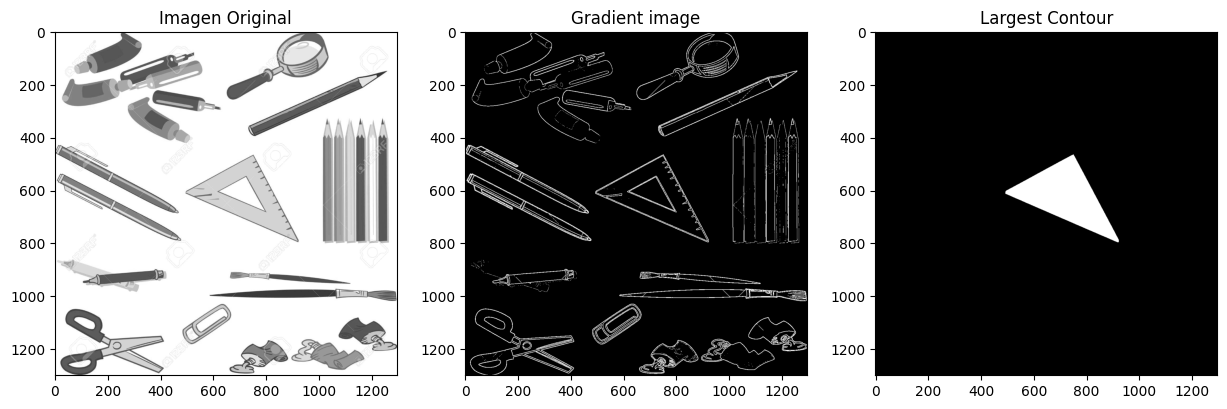

In [5]:
#objeto1
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 50

objeto1 = cv2.imread(images_path + "objeto1.jpg", 0)

biggestObject(objeto1, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

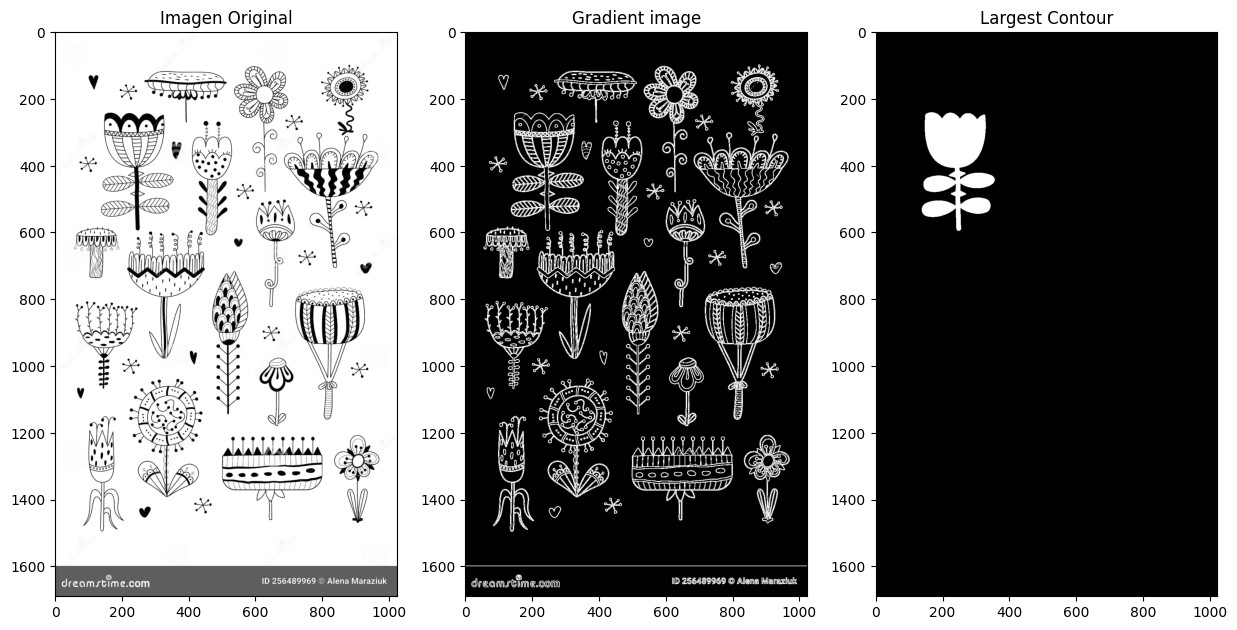

In [6]:
#objeto3
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 50

objeto3 = cv2.imread(images_path + "objeto4.jpg", 0)

biggestObject(objeto3, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

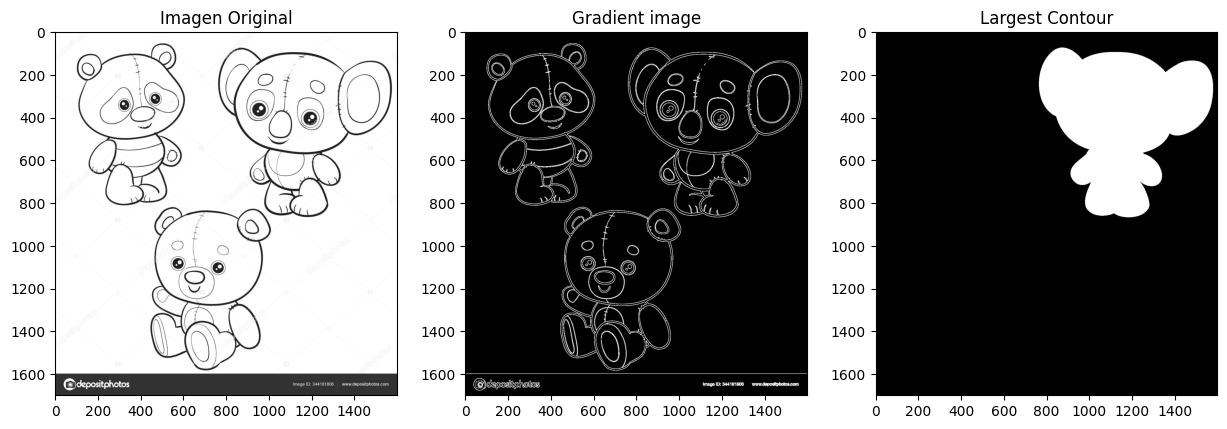

In [7]:
#objeto4
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 50

objeto4 = cv2.imread(images_path + "objeto5.jpg", 0)

biggestObject(objeto4, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

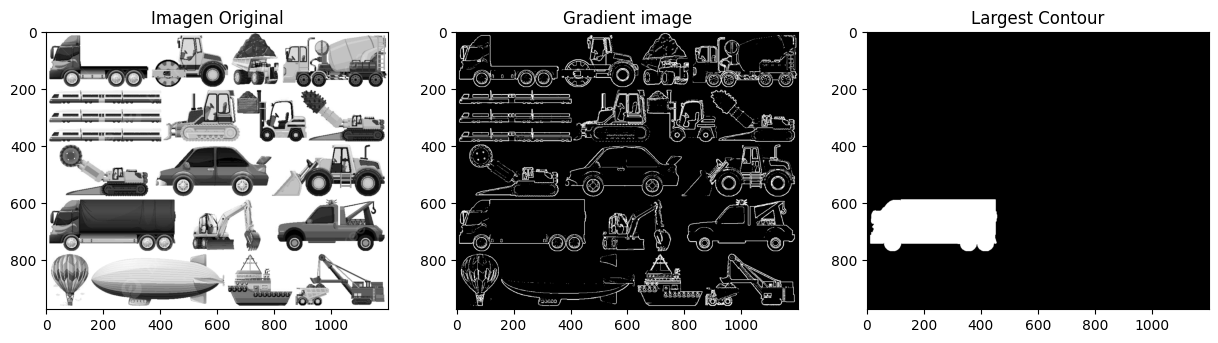

In [8]:
#objeto5
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 50

objeto5 = cv2.imread(images_path + "objeto5.png", 0)

biggestObject(objeto5, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

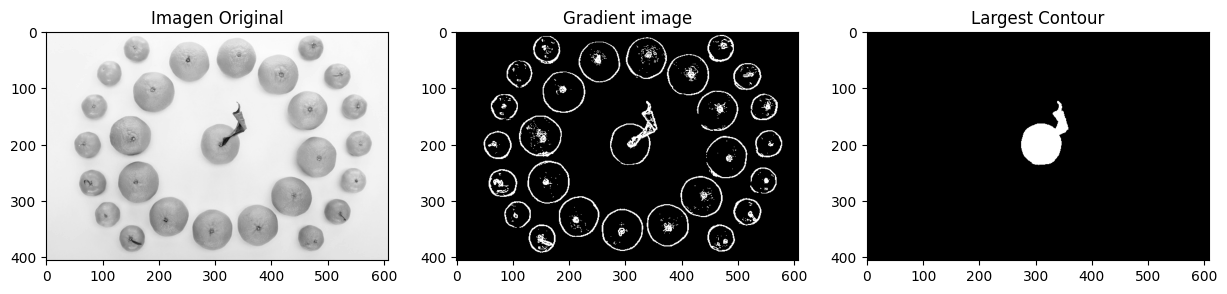

In [9]:
#objeto5
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 20

objeto5p = cv2.imread(images_path + "objeot6.jpeg", 0)

biggestObject(objeto5p, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

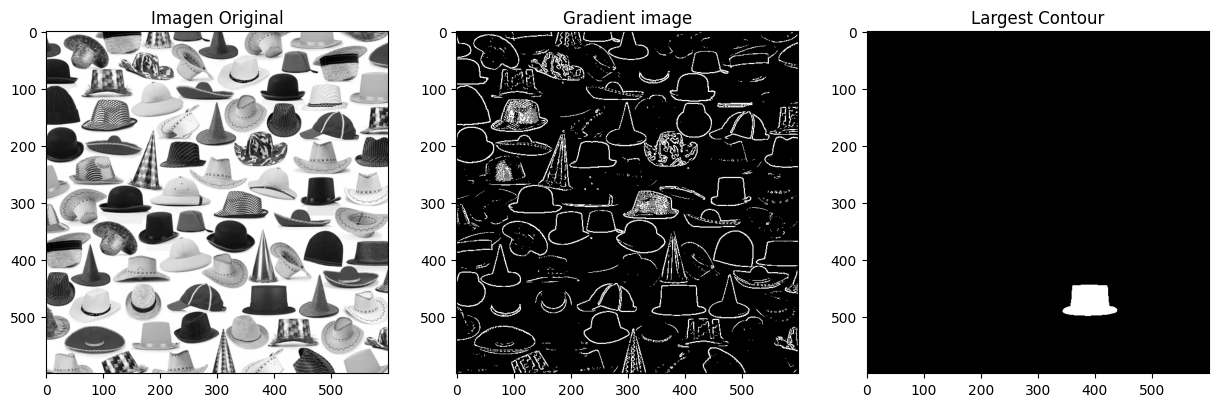

In [10]:
#objeto3
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 75

objeto3 = cv2.imread(images_path + "objeto3.jpg", 0)

biggestObject(objeto3, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

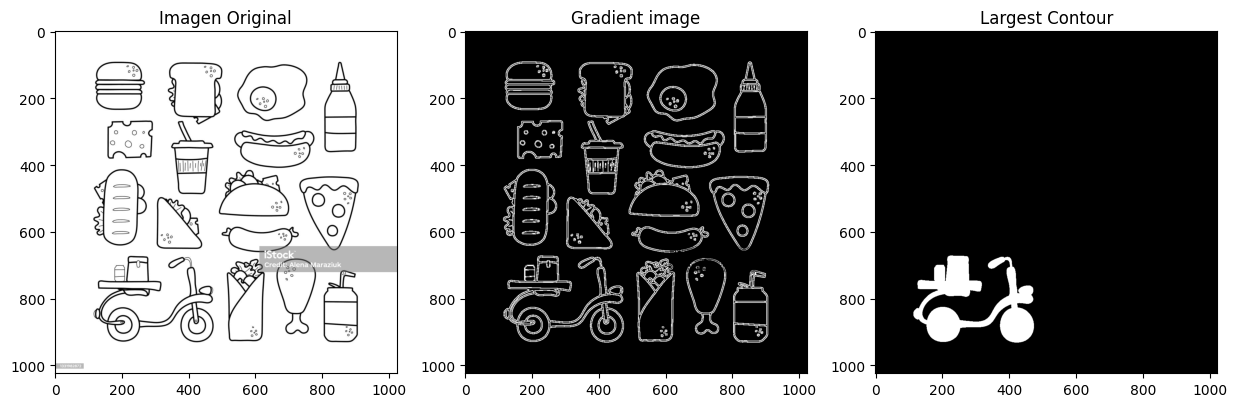

In [11]:
#objeto7
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 80

objeto7 = cv2.imread(images_path + "obj.jpg", 0)

biggestObject(objeto7, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

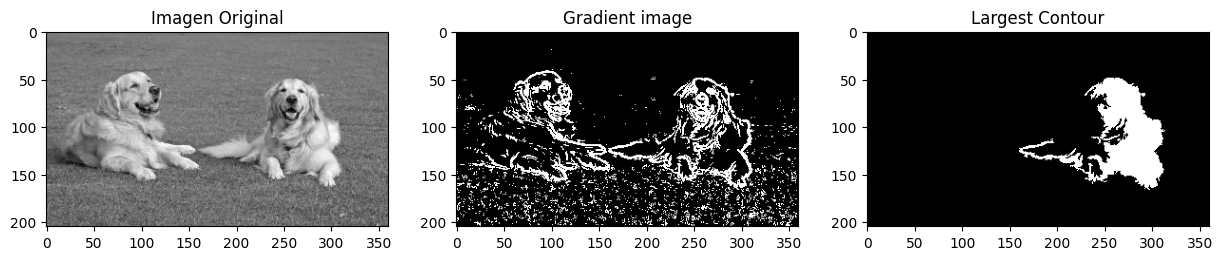

In [12]:
#objeto8
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 38

objeto8 = cv2.imread(images_path + "objeto8.jpg", 0)

biggestObject(objeto8, kernel_h, kernel_v, threshold, verbose=True)
plt.show()

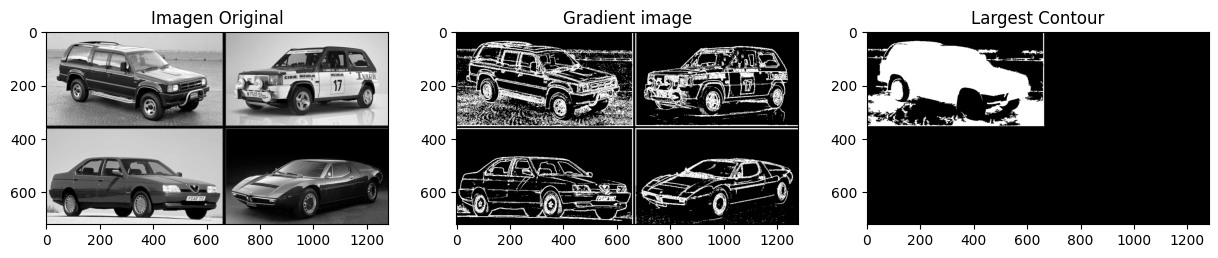

In [13]:
#objeto9
#kernel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
#kernel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4
threshold = 20

objeto9 = cv2.imread(images_path + "objeto9.jpg", 0)

biggestObject(objeto9, kernel_h, kernel_v, threshold, verbose=True)
plt.show()